# Generalise Huckel Solver

> Constructs the Huckel matrix and solves for the values, based on Ex 3.1 instructions

This solver will only work if all $p$ orbitals are equivalent (it will not consider for instance perturbations due to nitrogen in pyridine).
The Huckel theory assumptions are:
$$ H_{ij}= \begin{cases} \alpha,\  i=j\\ \beta,\  i \text{ adjacent to } j\\ 0,\  \text{otherwise}\end{cases} $$
with scaling such that $\alpha = 0$ and $\beta =-1$. As such, it can be seen that the resulting Huckel matrix is the negative of the adjacency matrix $A$ where: 
$$ A_{ij}= \begin{cases}  1,\  i \text{ adjacent to } j\\ 0,\  \text{otherwise}\end{cases} $$

In [ ]:
#| default_exp huckel

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| export
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
IPythonConsole.drawOptions.addAtomIndices = True

In [ ]:
#| export
def generate_smiles(type, n):
    """
    generate the smiles of either a straight chain or ring polyene, with n atoms.
    All carbons will be sp2 hybridised.
    For linear molecules with an odd number of atoms it will return the anion
    For rings with 4n+1 atoms it will return the anion eg C5H5-    
    For rings with 4n+3 atoms it will return the cation eg C7H7+   
    """
    unit = 'C=C'# the base 2 carbon double bond unit
    if n<3: type = 'linear' #ring needs at least 3 atoms
    if n <=1: 
        raise Exception("More than 1 Carbon atoms is needed")
    if not isinstance(n, int): 
        raise Exception("An integer number of atoms is needed")
    if type == 'linear':
        repeats = n//2 # repeats of the base unit of 2 carbons
        terminal = n%2 # whether or not a terminal carbon is needed
        output = repeats*unit +terminal*"[CH2+]"
    if type == 'ring':
        repeats = n//2 # repeats of the base unit of 2 carbons
        cation_terminal = 1 if n%4==3 else 0 # if 4n+3 carbon atoms: cation eg C7H7+
        anion_terminal = 1 if n%4==1 else 0 # if 4n+3 carbon atoms: cation eg C5H5-
        output = "C1=C" +(repeats-1)*unit +anion_terminal*"[CH-]"+cation_terminal*"[CH+]"+"1"
    return(output)

In [ ]:
#| export
def Huckel_solve(SMILES):
    """
    From a SMILES input, create an adjacency matrix, and use that to solve the for the Huckel pi system
    Returns a dictionary of energy levels with the associated (possibly degenerate) wavefunctions and the RDKit molecule
    This only considers 1 sort of p orbital and treats alpha =0 and beta = -1
    """
    molecule = Chem.MolFromSmiles(SMILES)
    mat = -Chem.GetAdjacencyMatrix(molecule)
    vals, vecs = np.linalg.eig(mat)
    # create dictionary where each eigenvalue has a list of the associated eigenvectors
    energy_dict = {}
    for i, val in enumerate(vals):
        # pythons eigenvalues sometimes produce rounding errors at the 14th dp: eg eigenvalues for benzene being 1.0 and 0.9999999999999998
        # similarly, trivial imaginary parts are occasionally produced: on the order of 10^-16 i
        val = round(np.real(val), 3) 
        if val in energy_dict:energy_dict[val].append(vecs[:,i])
        else: energy_dict[val]=[vecs[:,i]]
    return molecule, energy_dict 

In [ ]:
#| export
def MO_plot(dict):
    """
    Plots an MO diagram based on a dictionary of energy levels and associated wavefunctions
    """
    fig, ax = plt.subplots()
    for level in dict:
        degeneracy = len(dict[level])
        x = np.arange(-(0.5*(degeneracy - 1)),(0.5*(degeneracy)), 1)
        y = [level]*(degeneracy)
        ax.scatter(x, y, s =900, marker = '_', linewidth = 3)
    plt.show

This works in a straightforward manner for chains and rings

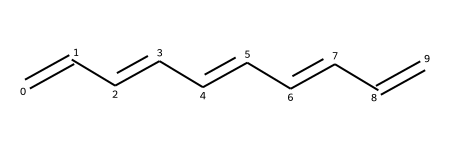

In [ ]:
mol = generate_smiles('linear', 10)
molecule, energy_dict = Huckel_solve(mol)
molecule

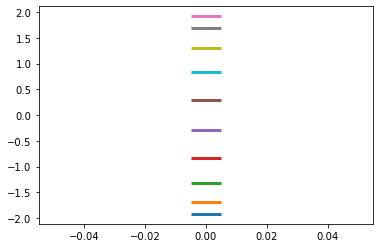

In [ ]:
MO_plot(energy_dict)

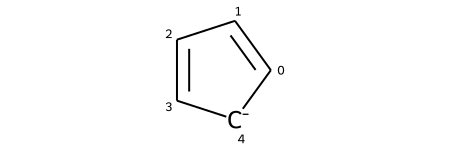

In [ ]:
mol = generate_smiles('ring', 5)
molecule, energy_dict = Huckel_solve(mol)
molecule

{1.618: [array([-0.63245553,  0.51166727, -0.19543951, -0.19543951,  0.51166727]), array([ 0.22920749, -0.53190907,  0.63143946, -0.48978144,  0.16104355])], -0.618: [array([ 0.63245553,  0.19543951, -0.51166727, -0.51166727,  0.19543951]), array([-0.07520313, -0.62047262, -0.30827004,  0.42995126,  0.57399453])], -2.0: [array([-0.4472136, -0.4472136, -0.4472136, -0.4472136, -0.4472136])]}


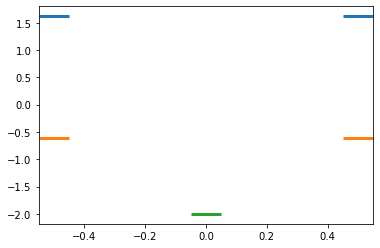

In [ ]:
print(energy_dict)
MO_plot(energy_dict)

Similarly, it works for more complkex 3d structures (though rdkit struggles to show their structure in the output skeletal diagram)

In [ ]:
tetrahedrane_smiles = 'C12C3C1C23'
cubane_smiles = 'C12C3C4C1C5C2C3C45'
dodecahedrane_smiles = 'C12C3C4C5C1C6C7C2C8C3C9C4C1C5C6C2C7C8C9C12'
fullerene_smiles = "c12c3c4c5c2c2c6c7c1c1c8c3c3c9c4c4c%10c5c5c2c2c6c6c%11c7c1c1c7c8c3c3c8c9c4c4c9c%10c5c5c2c2c6c6c%11c1c1c7c3c3c8c4c4c9c5c2c2c6c1c3c42"

In [ ]:
# rdkit does consider all bonds, even if all are not shown on the output skeletal diagram: this is mostly apparent for cubane
molecule = Chem.MolFromSmiles(cubane_smiles)
mat = -Chem.GetAdjacencyMatrix(molecule)
print(mat)

[[ 0 -1  0 -1  0 -1  0  0]
 [-1  0 -1  0  0  0 -1  0]
 [ 0 -1  0 -1  0  0  0 -1]
 [-1  0 -1  0 -1  0  0  0]
 [ 0  0  0 -1  0 -1  0 -1]
 [-1  0  0  0 -1  0 -1  0]
 [ 0 -1  0  0  0 -1  0 -1]
 [ 0  0 -1  0 -1  0 -1  0]]


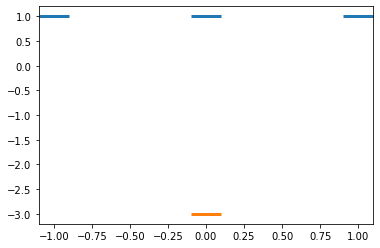

In [ ]:
molecule, energy_dict = Huckel_solve(tetrahedrane_smiles)
MO_plot(energy_dict)

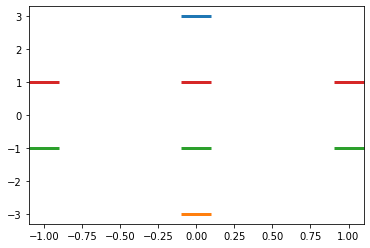

In [ ]:
molecule, energy_dict = Huckel_solve(cubane_smiles)
MO_plot(energy_dict)

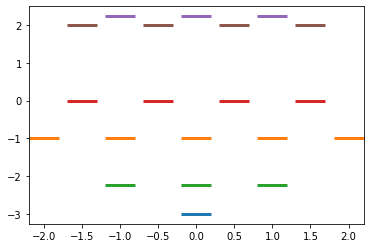

In [ ]:
molecule, energy_dict = Huckel_solve(dodecahedrane_smiles)
MO_plot(energy_dict)

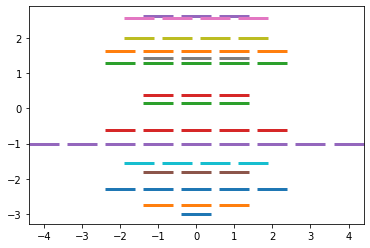

In [ ]:
molecule, energy_dict = Huckel_solve(fullerene_smiles)
MO_plot(energy_dict)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()